In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# heatmap
import math
from scipy.stats import multivariate_normal

# animation
from matplotlib.animation import FuncAnimation

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2023-04-16 17:36:50.958529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 17:36:51.158013: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 17:36:52.239345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-16 17:36:52.239532: W tensorflow/stream_executor

1 Physical GPUs, 1 Logical GPUs


2023-04-16 17:36:53.796280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 17:36:53.810719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 17:36:53.811153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 17:36:53.812498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# train.csv file
df = pd.read_csv(f"../data/train.csv")
df["path"] = df["path"].apply(lambda row: f"../data/{row}")
df.head()

,path,participant_id,sequence_id,sign
0,../data/train_landmark_files/26734/1000035562....,26734,1000035562,blow
1,../data/train_landmark_files/28656/1000106739....,28656,1000106739,wait
2,../data/train_landmark_files/16069/100015657.p...,16069,100015657,cloud
3,../data/train_landmark_files/25571/1000210073....,25571,1000210073,bird
4,../data/train_landmark_files/62590/1000240708....,62590,1000240708,owie


In [4]:
len(df)

94477

In [329]:
NUM_JOINTS = 543

LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
#     78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
#     95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

RIGHT_EYE = [
    246, 161, 160, 159, 158, 157, 173,
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    247, 30, 29, 27, 28, 56, 190,
    130, 25, 110, 24, 23, 22, 26, 112, 243,
    113, 225, 224, 223, 222, 221, 189,
    226, 31, 228, 229, 230, 231, 232, 233, 244,
    143, 111, 117, 118, 119, 120, 121, 128, 245,
]

LEFT_EYE = [
    466, 387, 386, 385, 384, 398,
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    467, 260, 259, 257, 258, 286, 414,
    359, 255, 339, 254, 253, 252, 256, 341, 463,
    342, 445, 444, 443, 442, 441, 413,
    446, 261, 448, 449, 450, 451, 452, 453, 464,
    372, 340, 346, 347, 348, 349, 350, 357, 465,
]

LEFT_HAND = [
    468, 469, 470, 471, 472, 473, 474, 475,
    476, 477, 478, 479, 480, 481, 482, 483,
    484, 485, 486, 487, 488
]

RIGHT_HAND = [
    522, 523, 524, 525, 526, 527, 528, 529,
    530, 531, 532, 533, 534, 535, 536, 537,
    538, 539, 540, 541, 542
]

POSE = [
    489, 490, 491, 492, 493, 494, 495, 496, 497,
    498, 499, 500, 501, 502, 503, 504, 505, 506,
    507, 508, 509, 510, 511, 512, 513, 514, 515,
    516, 517, 518, 519, 520, 521
]

In [330]:
idx = 100

landmark_df = pd.read_parquet(df.loc[idx].path)
landmark_df

,frame,row_id,type,landmark_index,x,y,z
0,0,0-face-0,face,0,0.425013,0.384484,-0.039359
1,0,0-face-1,face,1,0.414999,0.334925,-0.078130
2,0,0-face-2,face,2,0.419444,0.345982,-0.039070
3,0,0-face-3,face,3,0.397874,0.295141,-0.059470
4,0,0-face-4,face,4,0.412729,0.323081,-0.083896
...,...,...,...,...,...,...,...
32032,58,58-right_hand-16,right_hand,16,NaN,NaN,NaN
32033,58,58-right_hand-17,right_hand,17,NaN,NaN,NaN
32034,58,58-right_hand-18,right_hand,18,NaN,NaN,NaN
32035,58,58-right_hand-19,right_hand,19,NaN,NaN,NaN


In [331]:
tmp = landmark_df.loc[landmark_df.frame==0]
tmp.loc[tmp.type=="pose"]

,frame,row_id,type,landmark_index,x,y,z
489,0,0-pose-0,pose,0,0.427018,0.319976,-1.125882
490,0,0-pose-1,pose,1,0.468264,0.262829,-1.069302
491,0,0-pose-2,pose,2,0.499326,0.261374,-1.069536
492,0,0-pose-3,pose,3,0.523989,0.261058,-1.069469
493,0,0-pose-4,pose,4,0.372725,0.268568,-1.046240
494,0,0-pose-5,pose,5,0.346510,0.270600,-1.045546
495,0,0-pose-6,pose,6,0.325438,0.272631,-1.046191
496,0,0-pose-7,pose,7,0.565692,0.281926,-0.626231
497,0,0-pose-8,pose,8,0.306976,0.294595,-0.491890
498,0,0-pose-9,pose,9,0.492407,0.376978,-0.956025


In [332]:
print("Number of frames: ", int(len(landmark_df)/NUM_JOINTS))

Number of frames:  59


In [333]:
def generate_a_heatmap(arr, centers, max_values):
    """Generate pseudo heatmap for one keypoint in one frame.

    Args:
        arr (np.ndarray): The array to store the generated heatmaps. Shape: img_h * img_w.
        centers (np.ndarray): The coordinates of corresponding keypoints (of multiple persons). Shape: M * 2.
        max_values (np.ndarray): The max values of each keypoint. Shape: M.

    Returns:
        np.ndarray: The generated pseudo heatmap.
    """

    sigma = 0.1
    img_h, img_w = arr.shape

    for center, max_value in zip(centers, max_values):

        mu_x, mu_y = center[0], center[1]
        if not (np.isnan(mu_x) and np.isnan(mu_y)):
            # scale
            mu_x = min(math.floor(mu_x * img_w), img_w - 1)
            mu_y = min(math.floor(mu_y * img_h), img_h - 1)

            st_x = max(int(mu_x - 0.5 * sigma), 0)
            ed_x = min(int(mu_x + 0.5 * sigma) + 1, img_w)
            st_y = max(int(mu_y - 0.5 * sigma), 0)
            ed_y = min(int(mu_y + 0.5 * sigma) + 1, img_h)
            x = np.arange(st_x, ed_x, 1, np.float32)
            y = np.arange(st_y, ed_y, 1, np.float32)

            # if the keypoint not in the heatmap coordinate system
            if not (len(x) and len(y)):
                continue
            y = y[:, None]

            patch = np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / 2 / sigma**2)
            patch = patch * max_value
            arr[st_y:ed_y, st_x:ed_x] = np.maximum(arr[st_y:ed_y, st_x:ed_x], patch)

In [334]:
frames = landmark_df.frame.unique()

num_frame = len(frames)
num_c = 107
img_h = 56
img_w = 56

ret = np.zeros([num_frame, num_c, img_h, img_w], dtype=np.float32) # T x V x H x W (or T x K x H x W to match paper)
print(ret.shape)

faces, poses, rhs, lhs = [],[],[],[]
humans = []

for i, frame in tqdm(enumerate(frames)):
    arr = ret[i]

    # Get the frame and associated parts
    f = landmark_df.loc[landmark_df.frame == frame]
    face = f.loc[f.type == "face"][["x", "y", "z"]].values[LIP]
    pose = f.loc[f.type == "pose"][["x", "y", "z"]].values[:-8]
    rh = f.loc[f.type == "right_hand"][["x", "y", "z"]].values
    lh = f.loc[f.type == "left_hand"][["x", "y", "z"]].values

    human = np.concatenate([face, pose, rh, lh], axis=0)
    # normalize
    human = human[~np.ma.fix_invalid(human).mask.any(axis=1)]
    x, y = human[:,:1], human[:,1:2]

    # TODO: Normalize the whole sequence together
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    y = (y-np.min(y))/(np.max(y)-np.min(y))

    human = np.squeeze(np.array(list(zip(x, y))), axis=-1)
    
    kps = np.expand_dims(human, axis=0)
    all_kpscores = np.ones((1,num_frame,num_c), dtype=np.float32)
    kpscores = np.ones_like(all_kpscores[:, 0])

    num_kp = kps.shape[1]
    for i in range(num_kp):
        p = generate_a_heatmap(arr[i], kps[:, i], kpscores[:, i])

(59, 107, 56, 56)


59it [00:00, 140.26it/s]


In [18]:
human = np.concatenate([face, pose, rh, lh], axis=0)
human.shape

(107, 3)

In [19]:
np.min(x)

0.0

In [20]:
np.max(x)

1.0

In [21]:
mu_x, mu_y = kps[:,i][0][0], kps[:,i][0][1]

mu_x = min(math.floor(mu_x * img_w), img_w - 1)
mu_y = min(math.floor(mu_y * img_h), img_h - 1)

mu_x, mu_y

(26, 8)

In [22]:
sigma = 0.2
st_x = max(int(mu_x - 0.5 * sigma), 0)
ed_x = min(int(mu_x + 0.5 * sigma) + 1, img_w)
st_y = max(int(mu_y - 0.5 * sigma), 0)
ed_y = min(int(mu_y + 0.5 * sigma) + 1, img_h)
x = np.arange(st_x, ed_x, 1, np.float32)
y = np.arange(st_y, ed_y, 1, np.float32)

y = y[:, None]

ix = (x - mu_x)**2
jy = (y - mu_y)**2

patch = np.exp(-(ix + jy) / 2 / sigma**2)

In [23]:
st_x, ed_x

(25, 27)

In [24]:
st_y, ed_y

(7, 9)

In [25]:
x

array([25., 26.], dtype=float32)

In [26]:
y

array([[7.],
       [8.]], dtype=float32)

In [27]:
patch

array([[1.3887944e-11, 3.7266529e-06],
       [3.7266529e-06, 1.0000000e+00]], dtype=float32)

In [28]:
ix

array([1., 0.], dtype=float32)

In [29]:
jy

array([[1.],
       [0.]], dtype=float32)

In [30]:
ix + jy

array([[2., 1.],
       [1., 0.]], dtype=float32)

In [31]:
patch

array([[1.3887944e-11, 3.7266529e-06],
       [3.7266529e-06, 1.0000000e+00]], dtype=float32)

In [32]:
arr = ret[0][0]

arr[st_y:ed_y, st_x:ed_x] = np.maximum(arr[st_y:ed_y, st_x:ed_x], patch)

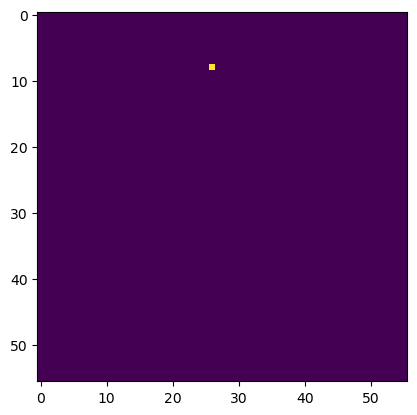

In [33]:
plt.imshow(arr)

In [34]:
tensor = [0, 0, 0, 0, 0, 0, 0, 0]
indices = [[1], [4], [5]]
updates = [1, -1, 1]
tf.tensor_scatter_nd_max(tensor, indices, updates).numpy()

array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int32)

####

In [204]:
import tensorflow as tf

human = np.concatenate([face, pose, rh, lh], axis=0)
humans = np.reshape(landmark_df[["x", "y", "z"]].values, newshape=(-1, 543, 3))

faces = tf.gather(humans, LIP, axis=1).numpy()
poses = tf.gather(humans, POSE, axis=1).numpy()[:,:-8]
rhs = tf.gather(humans, RIGHT_HAND, axis=1).numpy()
lhs = tf.gather(humans, LEFT_HAND, axis=1).numpy()

humans = tf.concat([faces, poses, rhs, lhs], axis=1)
humans.shape

TensorShape([59, 107, 3])

In [205]:
_x, _y = humans[:,:,:1], humans[:,:,1:2]
_x.shape, _y.shape

(TensorShape([59, 107, 1]), TensorShape([59, 107, 1]))

In [206]:
# MinMax Normalization
x_min = tf.reduce_min(tf.where(tf.math.is_nan(_x), tf.float32.max, _x), axis=1)
x_max = tf.reduce_max(tf.where(tf.math.is_nan(_x), tf.float32.min, _x), axis=1)
y_min = tf.reduce_min(tf.where(tf.math.is_nan(_y), tf.float32.max, _y), axis=1)
y_max = tf.reduce_max(tf.where(tf.math.is_nan(_y), tf.float32.min, _y), axis=1)

x_min = tf.expand_dims(x_min, axis=1)
x_max = tf.expand_dims(x_max, axis=1)
y_min = tf.expand_dims(y_min, axis=1)
y_max = tf.expand_dims(y_max, axis=1)

_x = (_x - x_min) / (x_max - x_min)
_y = (_y - y_min) / (y_max - y_min)

In [207]:
_x = tf.math.floor(_x * 56)
_y = tf.math.floor(_y * 56)

In [208]:
_x[0][0], _y[0][0]

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([26.])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([8.])>)

In [209]:
sigma = 0.1
_st_x = tf.math.maximum(tf.cast(_x - 0.5 * sigma, tf.int32), tf.constant(0, dtype=tf.int32))
_ed_x = tf.math.minimum(tf.cast(_x + 0.5 * sigma, tf.int32) + 1, tf.cast(56, tf.int32))
_st_y = tf.math.maximum(tf.cast(_y - 0.5 * sigma, tf.int32), tf.constant(0, dtype=tf.int32))
_ed_y = tf.math.minimum(tf.cast(_y + 0.5 * sigma, tf.int32) + 1, tf.cast(56, tf.int32))

In [210]:
_st_x[0][0], _ed_x[0][0]

(<tf.Tensor: shape=(1,), dtype=int32, numpy=array([25], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([27], dtype=int32)>)

In [211]:
_st_y[0][0], _ed_y[0][0]

(<tf.Tensor: shape=(1,), dtype=int32, numpy=array([7], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([9], dtype=int32)>)

In [212]:
i = tf.concat([_st_x, _ed_x-1], axis=-1)
j = tf.concat([_st_y, _ed_y-1], axis=-1)[..., None]

In [214]:
j

<tf.Tensor: shape=(59, 107, 2, 1), dtype=int32, numpy=
array([[[[          7],
         [          8]],

        [[          6],
         [          7]],

        [[          6],
         [          7]],

        ...,

        [[         23],
         [         24]],

        [[         24],
         [         25]],

        [[         25],
         [         26]]],


       [[[          6],
         [          7]],

        [[          6],
         [          7]],

        [[          6],
         [          7]],

        ...,

        [[          0],
         [-2147483648]],

        [[          0],
         [-2147483648]],

        [[          0],
         [-2147483648]]],


       [[[          6],
         [          7]],

        [[          6],
         [          7]],

        [[          6],
         [          7]],

        ...,

        [[          0],
         [-2147483648]],

        [[          0],
         [-2147483648]],

        [[          0],
         [-2147483648]]],

In [215]:
ix = (i - tf.cast(_x, tf.int32))**2
ix = tf.broadcast_to(tf.transpose(ix[..., tf.newaxis], (0,1,3,2)), (59, 107, 2, 2))
ix

<tf.Tensor: shape=(59, 107, 2, 2), dtype=int32, numpy=
array([[[[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        ...,

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]]],


       [[[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        ...,

        [[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]]],


       [[[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        ...,

        [[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]]],


       ...,


       [[[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        ...,

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0]]],


   

In [216]:
jy = (j - tf.cast(_y,tf.int32)[..., tf.newaxis])**2
jy

<tf.Tensor: shape=(59, 107, 2, 1), dtype=int32, numpy=
array([[[[1],
         [0]],

        [[1],
         [0]],

        [[1],
         [0]],

        ...,

        [[1],
         [0]],

        [[1],
         [0]],

        [[1],
         [0]]],


       [[[1],
         [0]],

        [[1],
         [0]],

        [[1],
         [0]],

        ...,

        [[0],
         [0]],

        [[0],
         [0]],

        [[0],
         [0]]],


       [[[1],
         [0]],

        [[1],
         [0]],

        [[1],
         [0]],

        ...,

        [[0],
         [0]],

        [[0],
         [0]],

        [[0],
         [0]]],


       ...,


       [[[1],
         [0]],

        [[1],
         [0]],

        [[1],
         [0]],

        ...,

        [[1],
         [0]],

        [[1],
         [0]],

        [[1],
         [0]]],


       [[[1],
         [0]],

        [[1],
         [0]],

        [[1],
         [0]],

        ...,

        [[1],
         [0]],

        [[1],

In [48]:
ix_jy = tf.cast(ix + jy, tf.float32)
ix_jy

<tf.Tensor: shape=(59, 107, 2, 2), dtype=float32, numpy=
array([[[[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        ...,

        [[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]]],


       [[[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       ...,


       [[[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        [[2., 1.],
         [1., 0.]],

        ...,

        [[2., 1.],
        

In [49]:
_patch = tf.exp(-ix_jy / 2 / sigma**2)

In [50]:
_patch

<tf.Tensor: shape=(59, 107, 2, 2), dtype=float32, numpy=
array([[[[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        [[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        [[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        ...,

        [[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        [[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        [[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]]],


       [[[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        [[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        [[0.0000000e+00, 1.9287499e-22],
         [1.9287499e-22, 1.0000000e+00]],

        ...,

        [[1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00]],

        [[1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.00000

In [132]:
_patch[0][0]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.0000000e+00, 1.9287499e-22],
       [1.9287499e-22, 1.0000000e+00]], dtype=float32)>

In [133]:
patch

array([[1.3887944e-11, 3.7266529e-06],
       [3.7266529e-06, 1.0000000e+00]], dtype=float32)

In [305]:
ret = tf.zeros((59, 107, 56, 56), dtype=tf.float32)
ret.shape

TensorShape([59, 107, 56, 56])

In [300]:
ret = tf.reshape(ret, shape=(59, 107, 56*56))
ret.shape

TensorShape([59, 107, 3136])

In [307]:
tf.tensor_scatter_nd_max(
    tensor=ret,
    indices=indices,
    updates=_patch
)

InvalidArgumentError: {{function_node __wrapped__TensorScatterMax_device_/job:localhost/replica:0/task:0/device:GPU:0}} Outer dimensions of indices and update must match. Indices shape: [59,107,4,2], updates shape:[59,107,2,2] [Op:TensorScatterMax]

In [157]:
tf.reduce_max(_ed_x - _st_x)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [224]:
i.shape

TensorShape([59, 107, 2])

In [225]:
j.shape

TensorShape([59, 107, 2, 1])

In [235]:
j[0][0]

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[7],
       [8]], dtype=int32)>

In [268]:
aaa = tf.concat([tf.expand_dims(i, axis=-1), j], axis=-1)
aaa

<tf.Tensor: shape=(59, 107, 2, 2), dtype=int32, numpy=
array([[[[         25,           7],
         [         26,           8]],

        [[         25,           6],
         [         26,           7]],

        [[         26,           6],
         [         27,           7]],

        ...,

        [[         40,          23],
         [         41,          24]],

        [[         41,          24],
         [         42,          25]],

        [[         43,          25],
         [         44,          26]]],


       [[[         23,           6],
         [         24,           7]],

        [[         23,           6],
         [         24,           7]],

        [[         24,           6],
         [         25,           7]],

        ...,

        [[          0,           0],
         [-2147483648, -2147483648]],

        [[          0,           0],
         [-2147483648, -2147483648]],

        [[          0,           0],
         [-2147483648, -2147483648]]],


 

In [269]:
bbb = tf.concat([tf.expand_dims(i, axis=-1), tf.reverse(j, axis=[2])], axis=-1)
bbb

<tf.Tensor: shape=(59, 107, 2, 2), dtype=int32, numpy=
array([[[[         25,           8],
         [         26,           7]],

        [[         25,           7],
         [         26,           6]],

        [[         26,           7],
         [         27,           6]],

        ...,

        [[         40,          24],
         [         41,          23]],

        [[         41,          25],
         [         42,          24]],

        [[         43,          26],
         [         44,          25]]],


       [[[         23,           7],
         [         24,           6]],

        [[         23,           7],
         [         24,           6]],

        [[         24,           7],
         [         25,           6]],

        ...,

        [[          0, -2147483648],
         [-2147483648,           0]],

        [[          0, -2147483648],
         [-2147483648,           0]],

        [[          0, -2147483648],
         [-2147483648,           0]]],


 

In [294]:
indices = tf.concat([aaa, bbb], axis=2)
indices.shape

TensorShape([59, 107, 4, 2])

In [314]:
ret.shape[2:]

TensorShape([56, 56])

In [246]:
(25, 7), (26, 8), (25, 8), (26, 7)

((25, 7), (26, 8), (25, 8), (26, 7))

In [309]:
tf.reshape(_patch, (59,107,4))

<tf.Tensor: shape=(59, 107, 4), dtype=float32, numpy=
array([[[0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        [0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        [0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        ...,
        [0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        [0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        [0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00]],

       [[0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        [0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        [0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],

       [[0.0000000e+00, 1.9287499e-22, 1.9287499e-22, 1.0000000e+00],
      

In [220]:
frames, keypoints, height, width = 59,107,56,56
video_batch = tf.zeros([frames, keypoints, height, width])
video_batch

<tf.Tensor: shape=(59, 107, 56, 56), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ...

In [222]:
indices = [[25,7]*] # num_updates=107, index_depth=1

In [219]:

new_images = tf.ones([
  # num_updates=3, inner_shape=(width, height, channels)
  107, 2, 2])
tf.tensor_scatter_nd_update(video_batch, indices, new_images)

<tf.Tensor: shape=(13, 11, 7, 5, 3), dtype=float32, numpy=
array([[[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         ...,

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]

In [18]:
f = landmark_df.loc[landmark_df.frame == frame]
face = f.loc[f.type == "face"][["x", "y", "z"]].values[LIP]
pose = f.loc[f.type == "pose"][["x", "y", "z"]].values[:-8]
rh = f.loc[f.type == "right_hand"][["x", "y", "z"]].values
lh = f.loc[f.type == "left_hand"][["x", "y", "z"]].values

human = np.concatenate([face, pose, rh, lh], axis=0)

human.shape

(107, 3)

In [24]:
num_kp = kps.shape[1]
num_kp
for i in range(num_kp):
    generate_a_heatmap(arr[i], kps[:, i], kpscores[:, i])

In [335]:
def vis_heatmaps(heatmaps, channel=-1, ratio=8):
    # if channel is -1, draw all keypoints / limbs on the same map
    import matplotlib.cm as cm
    heatmaps = [x.transpose(1, 2, 0) for x in heatmaps]
    h, w, _ = heatmaps[0].shape
    newh, neww = int(h * ratio), int(w * ratio)

    if channel == -1:
        heatmaps = [np.max(x, axis=-1) for x in heatmaps]
    cmap = cm.viridis
    heatmaps = [(cmap(x)[..., :3] * 255).astype(np.uint8) for x in heatmaps]
    heatmaps = [cv2.resize(x, (neww, newh)) for x in heatmaps]
    return heatmaps

In [336]:
import cv2

keypoint_humans = []

for arr in ret:
    keypoint_mapvis = vis_heatmaps(np.expand_dims(arr, axis=0), ratio=1)
    keypoint_humans.append(keypoint_mapvis[0])

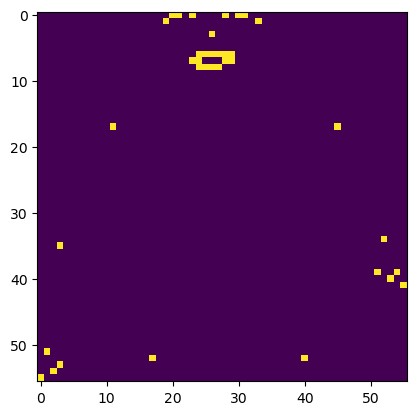

In [337]:
plt.imshow(keypoint_humans[3])

In [12]:
def points_to_gaussian_heatmap(centers, height, width, scale):
    gaussians = []
    for x,y in centers:
        s = np.eye(2)*scale
        
        if not (np.isnan(x) and np.isnan(y)):
            # unnormalize centers
            x = min(math.floor(x * width), width - 1)
            y = min(math.floor(y * height), height - 1)

            g = multivariate_normal(mean=(x,y), cov=s)
            gaussians.append(g)

    # create a grid of (x,y) coordinates at which to evaluate the kernels
    x = np.arange(0, width)
    y = np.arange(0, height)
    xx, yy = np.meshgrid(x,y)
    xxyy = np.stack([xx.ravel(), yy.ravel()]).T
    
    # evaluate kernels at grid points
    zz = sum(g.pdf(xxyy) for g in gaussians)
    
    if len(gaussians) !=0:
        img = zz.reshape((height,width))
    else:
        img = np.zeros(shape=(height, width))

    return img

W = 64  # width of heatmap
H = 64  # height of heatmap
SCALE = 0.5  # increase scale to make larger gaussians

In [13]:
frames = landmark_df.frame.unique()

faces, poses, rhs, lhs = [],[],[],[]
humans = []

for frame in tqdm(frames):
    # Get the frame and associated parts
    f = landmark_df.loc[landmark_df.frame == frame]
    face = f.loc[f.type == "face"][["x", "y", "z"]].values[LIP]
    pose = f.loc[f.type == "pose"][["x", "y", "z"]].values[:-8]
    rh = f.loc[f.type == "right_hand"][["x", "y", "z"]].values
    lh = f.loc[f.type == "left_hand"][["x", "y", "z"]].values

    human = np.concatenate([face, pose, rh, lh], axis=0)
    # normalize
    human = human[~np.ma.fix_invalid(human).mask.any(axis=1)]
    x, y = human[:,:1], human[:,1:2]
    
    # TODO: Normalize the whole sequence together
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    y = (y-np.min(y))/(np.max(y)-np.min(y))

    human = np.squeeze(np.array(list(zip(x, y))), axis=-1)

#     face_img = points_to_gaussian_heatmap(face[:,:2], H, W, SCALE)
#     pose_img = points_to_gaussian_heatmap(pose[:,:2], H, W, SCALE)
#     rh_img = points_to_gaussian_heatmap(rh[:,:2], H, W, SCALE)
#     lh_img = points_to_gaussian_heatmap(lh[:,:2], H, W, SCALE)
    
    img = points_to_gaussian_heatmap(human, H, W, SCALE)
    
#     faces.append(face_img)
#     poses.append(pose_img)
#     rhs.append(rh_img)
#     lhs.append(lh_img)
    
    humans.append(img)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 25.33it/s]


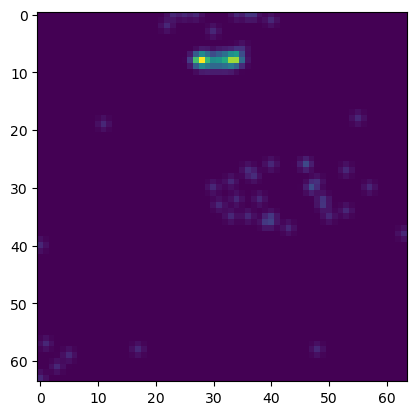

In [14]:
plt.imshow(img); plt.show()

In [183]:
humans

[]

In [338]:
fig, ax = plt.subplots(figsize=(5, 8))

arr = keypoint_humans

def update(i):
    im_normed = arr[i]
    ax.imshow(im_normed)
    ax.set_title(f"human_{i}", fontsize=20)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, len(arr)), interval=10)
anim.save('humanpose3d2.gif', dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


In [376]:
np.array(keypoint_humans).shape

(59, 56, 56, 3)

In [354]:
hall = tf.cast(tf.expand_dims(np.array(keypoint_humans), axis=0), tf.float32)
hall.shape

TensorShape([1, 59, 56, 56, 3])

In [357]:
halla = tf.keras.layers.Conv3D(32, 7, activation='relu', input_shape=hall.shape[1:])(hall)
halla.shape

TensorShape([1, 53, 50, 50, 32])

In [34]:
np.array(humans).shape

(59, 64, 64)

In [108]:
import tensorflow as tf

In [79]:
# The inputs are 28x28x28 volumes with a single channel, and the
# batch size is 4
input_shape = ret.shape+(1,)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv3D(32, 7, activation='relu', input_shape=input_shape[1:])(x)
print(y.shape)

(59, 101, 58, 58, 32)


In [117]:
ret.shape

(59, 107, 56, 56)

In [206]:
kps[:,0], kpscores[:,0]

(array([[0.42753562, 0.13543811]]), array([1.], dtype=float32))

In [207]:
center, max_value = kps[:,0][0], kpscores[:,0][0]
center, max_value

(array([0.42753562, 0.13543811]), 1.0)

In [208]:
ret = np.zeros([num_frame, num_c, img_h, img_w], dtype=np.float32) # T x V x H x W (or T x K x H x W to match paper)
print(ret.shape)
arr = ret[0][0]
arr, arr.shape

(59, 107, 56, 56)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 (56, 56))

In [209]:
sigma = 0.1
img_h, img_w = arr.shape

mu_x, mu_y = center[0], center[1]

# scale
mu_x = min(math.floor(mu_x * img_w), img_w - 1)
mu_y = min(math.floor(mu_y * img_h), img_h - 1)
mu_x, mu_y

(23, 7)

In [210]:
st_x = max(int(mu_x - 0.5 * sigma), 0)
ed_x = min(int(mu_x + 0.5 * sigma) + 1, img_w)
st_y = max(int(mu_y - 0.5 * sigma), 0)
ed_y = min(int(mu_y + 0.5 * sigma) + 1, img_h)

In [211]:
st_x, ed_x

(22, 24)

In [212]:
st_y, ed_y

(6, 8)

In [213]:
i = np.arange(st_x, ed_x, 1, np.float32)
j = np.arange(st_y, ed_y, 1, np.float32)[:, None]
i, j

(array([22., 23.], dtype=float32),
 array([[6.],
        [7.]], dtype=float32))

In [214]:
ix = (i - mu_x)**2
jy = (j - mu_y)**2
ix, jy

(array([1., 0.], dtype=float32),
 array([[1.],
        [0.]], dtype=float32))

In [216]:
np.exp(-(ix+jy)/2/sigma**2)

array([[3.7835059e-44, 1.9287499e-22],
       [1.9287499e-22, 1.0000000e+00]], dtype=float32)

In [176]:
patch = np.exp(-(ix + jy) / 2 / sigma**2)
# patch = patch * max_value
# arr[st_y:ed_y, st_x:ed_x] = np.maximum(arr[st_y:ed_y, st_x:ed_x], patch)

print("***************")
print(patch)
print("***************")            

***************
[[3.72007598e-44 1.92874985e-22]
 [1.92874985e-22 1.00000000e+00]]
***************


####

In [217]:
x, y = center[0], center[1]
x, y

(0.42753561967159237, 0.13543811273522272)

In [218]:
# Scale
x = tf.math.floor(x * 56)
y = tf.math.floor(y * 56)

In [219]:
x, y

(<tf.Tensor: shape=(), dtype=float64, numpy=23.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=7.0>)

In [220]:
st_x = tf.math.maximum(tf.cast(x - 0.5 * sigma, tf.int32), tf.constant(0, dtype=tf.int32))
ed_x = tf.math.minimum(tf.cast(x + 0.5 * sigma, tf.int32) + 1, tf.cast(56, tf.int32))
st_y = tf.math.maximum(tf.cast(y - 0.5 * sigma, tf.int32), tf.constant(0, dtype=tf.int32))
ed_y = tf.math.minimum(tf.cast(y + 0.5 * sigma, tf.int32) + 1, tf.cast(56, tf.int32))

In [221]:
st_x, ed_x

(<tf.Tensor: shape=(), dtype=int32, numpy=22>,
 <tf.Tensor: shape=(), dtype=int32, numpy=24>)

In [222]:
st_y, ed_y

(<tf.Tensor: shape=(), dtype=int32, numpy=6>,
 <tf.Tensor: shape=(), dtype=int32, numpy=8>)

In [223]:
i = tf.concat([st_x, ed_x-1], axis=0)
j = tf.concat([st_y, ed_y-1], axis=0)[..., None]
i, j

(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([22, 23], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[6],
        [7]], dtype=int32)>)

In [225]:
ix = (i - tf.cast(x, tf.int32))**2
ix

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>

In [226]:
jy = (j - tf.cast(y,tf.int32)[..., tf.newaxis])**2
jy

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[1],
       [0]], dtype=int32)>

In [227]:
ix+jy

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 1],
       [1, 0]], dtype=int32)>

In [532]:
a = tf.constant([[1,0], [1,0]])
a

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 0],
       [1, 0]], dtype=int32)>

In [533]:
b = tf.constant([[1,], [0,]])
b

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[1],
       [0]], dtype=int32)>

In [534]:
a + b

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 1],
       [1, 0]], dtype=int32)>